In [1]:
import tensorflow as tf
import numpy as np
import sympy as sp
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = True

In [2]:
PATH = '/Volumes/TheVault/Documentos Mac/Documentos Universidad/4o Curso/2o Cuatrimestre/Trabajo de Fin de Grado/maestro-v3.0.0/'
N_NOTES = 88
SAMPLING_RATE = 16000

In [3]:
def get_dataframe(path=PATH + 'maestro-v3.0.0.csv'):
    return pd.read_csv(path)

In [4]:
df = get_dataframe()
df.head()

,Unnamed: 0,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,data_cached,epochs_trained
0,0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,True,0
1,1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,True,0
2,2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,True,0
3,3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,True,0
4,4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,True,0


In [5]:
from utils.wav_handler import Wav_handler
wav_hdlr = Wav_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH)

In [6]:
# Constates relativas a la compresión con la mu-law
N_BITS = 5
N_LEVELS = 2 ** N_BITS
MU = 256
AMPS = (-1, 1)

In [7]:
from utils.mu_law_encoder import Mu_law_encoder
mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)

In [8]:
def calculate_receptive_field(n_blocks, n_layers):
    return sum([2 ** i for i in range(n_layers)] * n_blocks) - n_blocks + 1

In [9]:
# Parámetros que definen la arquitectura del modelo a crear por defecto en las llamadas a get_wavenet()

# Parámetros de la arquitectura interna de la red
N_FILTERS = N_LEVELS
FILTER_WIDTH = 2

# Main wavenet
N_BLOCKS = 6
K_LAYERS = 10

# Context stack
CONTEXT_BLOCKS = 2
CONTEXT_LAYERS = 6

# Números y longitudes de ejemplos de entrada, salida y local conditioning
INPUT_LEN = calculate_receptive_field(N_BLOCKS, K_LAYERS)
N_IN_CHANNELS = N_LEVELS
LC_LEN = 1
N_LC_CHANNELS = N_NOTES

# Dimensionalidad de input/output/local conditioning
INP_SHAPE = (INPUT_LEN, N_IN_CHANNELS)
OUT_SHAPE = INP_SHAPE
LC_SHAPE = (LC_LEN, N_LC_CHANNELS)

In [10]:
'''
    Método que devuelve el modelo de una wavenet implementada en tensorflow. Dicha red se construye
    de acuerdo a los parámetros de entrada.
'''
def get_wavenet(inp_shape=INP_SHAPE, out_shape=OUT_SHAPE, lc_shape=LC_SHAPE, n_filters=N_FILTERS,
                filter_width=FILTER_WIDTH, k_layers=K_LAYERS, n_blocks=N_BLOCKS,
                context_layers=CONTEXT_LAYERS, context_blocks=CONTEXT_BLOCKS):

    # Skip connections
    skips = []

    # Dilation rates
    dilations_per_block = [2 ** i for i in range(k_layers)] * n_blocks
    dilations_per_ctx_block = [2 ** i for i in range(context_layers)] * context_blocks

    # Local Conditioning
    Input_lc = tf.keras.layers.Input(shape=lc_shape, dtype='float32', name='lc')
    lc = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal')(Input_lc)

    # Context stack
    for dilation_rate in dilations_per_ctx_block:

        # Convolución y gated activation
        lc_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal',
                                        dilation_rate=dilation_rate)(lc)
        gated_act = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(lc),
                                        tf.keras.layers.Activation('sigmoid')(lc)])
        gated_act = tf.keras.layers.Conv1D(1, 1, padding='same')(gated_act)

        # Residual connection
        lc = tf.keras.layers.Add()([lc, gated_act])

    # Input
    Input_seq = tf.keras.layers.Input(shape=inp_shape, dtype='float32', name='seq')
    seq = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal')(Input_seq)

    for dilation_rate in dilations_per_block:

        # Sumamos la información del local conditioning a la convolución de los valores de audio
        seq_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal',
                                        dilation_rate=dilation_rate)(seq)
        tmp = tf.keras.layers.Add()([seq_conv, lc])

        # Gated activation
        gated_act = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(tmp),
                                        tf.keras.layers.Activation('sigmoid')(tmp)])

        gated_act = tf.keras.layers.Conv1D(1, 1, padding='same')(gated_act)

        # Residual connection
        seq = tf.keras.layers.Add()([seq, gated_act])

        # Vamos añadiendo las 'Skip conections'
        skips.append(gated_act)

    # Sumamos todas las skip connections y computamos el resto de funciones
    out = tf.keras.layers.Add()(skips)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(1, 1, padding='same')(out)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(out_shape[1], 1, padding='same')(out)
    out = tf.keras.layers.Softmax()(out)
    return tf.keras.models.Model(inputs=[Input_seq, Input_lc], outputs=out)

model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-06-21 14:11:50.023835: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lc (InputLayer)                [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 32)        5664        ['lc[0][0]']                     
                                                                                                  
 activation (Activation)        (None, 1, 32)        0           ['conv1d[0][0]']                 
                                                                                                  
 activation_1 (Activation)      (None, 1, 32)        0           ['conv1d[0][0]']                 
                                                                                              

In [37]:
param_values = []
error_values = []
wav_values = wav_hdlr.vectorize_wav(df['audio_filename'][0])

In [38]:
for i in range(1, 14):
    print(i)
    N_BITS = i
    N_LEVELS = 2 ** N_BITS
    N_FILTERS = N_LEVELS
    N_IN_CHANNELS = N_LEVELS
    INP_SHAPE = (INPUT_LEN, N_IN_CHANNELS)
    OUT_SHAPE = INP_SHAPE

    model = get_wavenet(n_filters=N_FILTERS, inp_shape=INP_SHAPE, out_shape=OUT_SHAPE)
    print(param_values)
    param_values.append(*[np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])])

1
[]
2
[1186]
3
[1186, 3274]
4
[1186, 3274, 10378]
5
[1186, 3274, 10378, 36298]
6
[1186, 3274, 10378, 36298, 134986]
7
[1186, 3274, 10378, 36298, 134986, 519754]
8
[1186, 3274, 10378, 36298, 134986, 519754, 2038858]
9
[1186, 3274, 10378, 36298, 134986, 519754, 2038858, 8075338]
10
[1186, 3274, 10378, 36298, 134986, 519754, 2038858, 8075338, 32141386]
11
[1186, 3274, 10378, 36298, 134986, 519754, 2038858, 8075338, 32141386, 128245834]
12
[1186, 3274, 10378, 36298, 134986, 519754, 2038858, 8075338, 32141386, 128245834, 512344138]
13
[1186, 3274, 10378, 36298, 134986, 519754, 2038858, 8075338, 32141386, 128245834, 512344138, 2048098378]


In [39]:
error_values = []
for i in range(1, 14):
    print(i)
    N_BITS = i
    N_LEVELS = 2 ** N_BITS
    N_FILTERS = N_LEVELS
    N_IN_CHANNELS = N_LEVELS
    INP_SHAPE = (INPUT_LEN, N_IN_CHANNELS)
    OUT_SHAPE = INP_SHAPE

    mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)
    wav_aprox = mulaw_enc.decode_series(mulaw_enc.encode_series(wav_values))
    errors = 0

    for i, j in zip(wav_aprox, wav_values):
        errors += abs(i - j)

    print(error_values)
    error_values.append(errors)

1
[]
2
[10927090.000752347]
3
[10927090.000752347, 427903.87257362634]
4
[10927090.000752347, 427903.87257362634, 165356.44188761752]
5
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234]
6
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234, 34585.18907870839]
7
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234, 34585.18907870839, 16981.89938183603]
8
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234, 34585.18907870839, 16981.89938183603, 8424.414700518377]
9
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234, 34585.18907870839, 16981.89938183603, 8424.414700518377, 4191.950134060881]
10
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234, 34585.18907870839, 16981.89938183603, 8424.414700518377, 4191.950134060881, 2093.5125648858593]
11
[10927090.000752347, 427903.87257362634, 165356.44188761752, 72094.47027923234, 3458

In [40]:
param_values_norm = (param_values - min(param_values))/(max(param_values) - min(param_values))

In [41]:
error_values_norm = (error_values - min(error_values))/(max(error_values) - min(error_values))

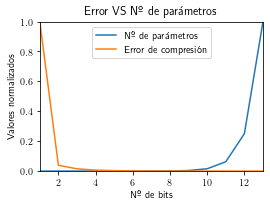

In [74]:
# Plotting sigmoid function
plt.figure(figsize=(4,2.75))
plt.plot(range(1, 14), param_values_norm, label='Nº de parámetros')
plt.plot(range(1, 14), error_values_norm, label='Error de compresión')
plt.legend(loc="upper center")
plt.title('Error VS Nº de parámetros')
plt.xlabel('Nº de bits')
plt.ylabel('Valores normalizados')
plt.xlim(1, 13)
plt.ylim(0, 1)
plt.savefig('ErrVSParams.png', bbox_inches='tight', dpi=600)

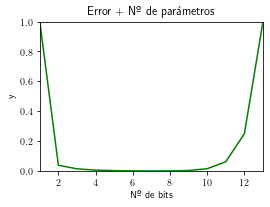

In [77]:
# Plotting sigmoid function
plt.figure(figsize=(4,2.75))
plt.plot(range(1, 14), param_values_norm + error_values_norm, color='green')
plt.title('Error + Nº de parámetros')
plt.xlabel('Nº de bits')
plt.ylabel('y')
plt.xlim(1, 13)
plt.ylim(0, 1)
plt.savefig('ErrPlusParams.png', bbox_inches='tight', dpi=600)

In [5]:
df['audio_filename'][0]

'2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav'